### 이 노트북을 실행하려면 GPU 런타임이 필요합니다.
### 메뉴 옵션 "런타임" -> "런타임 유형 변경"을 선택하고 "하드웨어 가속기" -> "GPU"를 선택한 다음 "저장"을 클릭하십시오.

-------------------------------------------------- --------------------

# 타코트론 2

*저자: 엔비디아*

**텍스트에서 mel 스펙트로그램을 생성하기 위한 Tacotron 2 모델**

<img src="https://pytorch.org/assets/images/tacotron2_diagram.png" alt="alt" width="50%"/>



### 모델 설명

Tacotron 2 및 WaveGlow 모델은 사용자가 추가 운율 정보 없이 원본 대본에서 자연스러운 음성을 합성할 수 있는 텍스트 음성 변환 시스템을 형성합니다. Tacotron 2 모델은 인코더-디코더 아키텍처를 사용하여 입력 텍스트에서 멜 스펙트로그램을 생성합니다. WaveGlow(torch.hub를 통해서도 사용 가능)는 mel 스펙트로그램을 사용하여 음성을 생성하는 흐름 기반 모델입니다.

이 Tacotron 2 모델의 구현은 논문에서 설명한 모델과 다릅니다. 구현에서는 Zoneout 대신 Dropout을 사용하여 LSTM 레이어를 정규화합니다.

### 예

아래 예에서:
- 사전 훈련된 Tacotron2 및 Waveglow 모델은 torch.hub에서 로드됩니다.
- 입력 텍스트("Hello world, I missing you so much")의 텐서 표현이 주어지면 Tacotron2는 그림과 같이 Mel 스펙트로그램을 생성합니다.
- Waveglow는 멜 스펙트로그램이 주어진 사운드를 생성합니다.
- 출력되는 소리는 'audio.wav' 파일에 저장됩니다.

예제를 실행하려면 추가 Python 패키지가 설치되어 있어야 합니다.
이는 텍스트 및 오디오 전처리와 디스플레이 및 입력/출력에 필요합니다.

In [1]:
%%bash
pip install numpy scipy librosa unidecode inflect
apt-get update
apt-get install -y libsndfile1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.9/235.9 KB 5.8 MB/s eta 0:00:00
Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:6 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:11 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [83.3 kB

[LJ 음성 데이터 세트](https://keithito.com/LJ-Speech-Dataset/)에서 사전 훈련된 Tacotron2 모델을 로드하고 추론을 준비합니다.

In [2]:
import torch
tacotron2 = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_tacotron2', model_math='fp16')
tacotron2 = tacotron2.to('cuda')
tacotron2.eval()

/usr/local/lib/python3.8/dist-packages/torch/hub.py:267: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/NVIDIA/DeepLearningExamples/zipball/torchhub" to /root/.cache/torch/hub/torchhub.zip
/root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/common.py:13: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(

Tacotron2(
  (embedding): Embedding(148, 512)
  (encoder): Encoder(
    (convolutions): ModuleList(
      (0): Sequential(
        (0): ConvNorm(
          (conv): Conv1d(512, 512, kernel_size=(5,), stride=(1,), padding=(2,))
        )
        (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): Sequential(
        (0): ConvNorm(
          (conv): Conv1d(512, 512, kernel_size=(5,), stride=(1,), padding=(2,))
        )
        (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (2): Sequential(
        (0): ConvNorm(
          (conv): Conv1d(512, 512, kernel_size=(5,), stride=(1,), padding=(2,))
        )
        (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (lstm): LSTM(512, 256, batch_first=True, bidirectional=True)
  )
  (decoder): Decoder(
    (prenet): Prenet(
      (layers): ModuleList(
        (0): LinearNorm(
          (lin

사전 훈련된 WaveGlow 모델 로드

In [3]:
waveglow = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_waveglow', model_math='fp16')
waveglow = waveglow.remove_weightnorm(waveglow)
waveglow = waveglow.to('cuda')
waveglow.eval()

Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


WaveGlow(
  (upsample): ConvTranspose1d(80, 80, kernel_size=(1024,), stride=(256,))
  (WN): ModuleList(
    (0): WN(
      (in_layers): ModuleList(
        (0): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
        (1): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,))
        (2): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(4,), dilation=(4,))
        (3): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(8,), dilation=(8,))
        (4): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(16,), dilation=(16,))
        (5): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(32,), dilation=(32,))
        (6): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(64,), dilation=(64,))
        (7): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(128,), dilation=(128,))
      )
      (res_skip_layers): ModuleList(
        (0): Conv1d(512, 1024, kernel_size=(1,), stride=(1,))
        (1): Conv1d(51

이제 모델이 다음과 같이 말하도록 합시다.

In [15]:
# text = "Hello world, I missed you so much."
text = "implements features as standalone functions."

유틸리티 메서드를 사용하여 입력 형식 지정

In [16]:
utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_tts_utils')
sequences, lengths = utils.prepare_input_sequence([text])

Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


In [17]:
print(sequences, lengths)

tensor([[46, 50, 53, 49, 42, 50, 42, 51, 57, 56, 11, 43, 42, 38, 57, 58, 55, 42,
         56, 11, 38, 56, 11, 56, 57, 38, 51, 41, 38, 49, 52, 51, 42, 11, 43, 58,
         51, 40, 57, 46, 52, 51, 56,  7]], device='cuda:0') tensor([44], device='cuda:0')


연결된 모델을 실행합니다.

In [18]:
with torch.no_grad():
    mel, _, _ = tacotron2.infer(sequences, lengths)
    audio = waveglow.infer(mel)
audio_numpy = audio[0].data.cpu().numpy()
rate = 22050

In [19]:
mel.shape

torch.Size([1, 80, 250])

In [20]:
import matplotlib.pyplot as plt
import librosa

def plot_spectrogram(specgram, title=None, ylabel="freq_bin"):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Spectrogram (db)")
    axs.set_ylabel(ylabel)
    axs.set_xlabel("frame")
    # im = axs.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto")
    im = axs.imshow(specgram, origin="lower", aspect="auto")
    fig.colorbar(im, ax=axs)
    plt.show(block=False)

In [21]:
def plot_waveform(waveform, sample_rate):
    # waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
    figure.suptitle("waveform")
    plt.show(block=False)

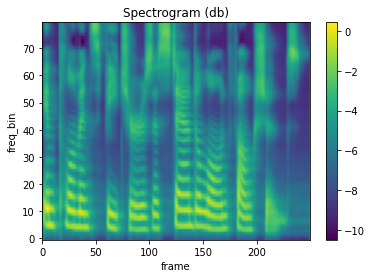

In [22]:
plot_spectrogram(mel.cpu()[0])

(64000,)


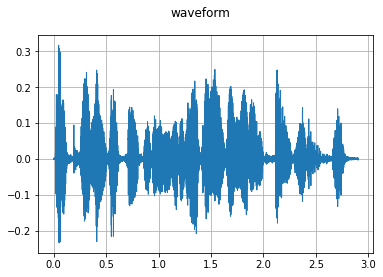

In [23]:
print(audio_numpy.shape)
rate = 22050
plot_waveform(audio_numpy.reshape(1,-1), rate)

파일에 쓰고 들을 수 있습니다.

In [24]:
from scipy.io.wavfile import write
write("audio.wav", rate, audio_numpy)

IPython 위젯이 있는 노트북에서 바로 재생

In [25]:
from IPython.display import Audio
print(rate)
Audio(audio_numpy, rate=rate)

22050



### 세부 정보
모델 입력 및 출력, 교육 방법, 추론 및 성능에 대한 자세한 내용은 [github](https://github.com/NVIDIA/DeepLearningExamples/tree/master/PyTorch/SpeechSynthesis/Tacotron2) 및/또는 [NGC](를 방문하세요. https://ngc.nvidia.com/catalog/resources/nvidia:tacotron_2_and_waveglow_for_pytorch)

### 참조

  - [Mel 스펙트로그램 예측에서 WaveNet을 컨디셔닝하여 자연 TTS 합성](https://arxiv.org/abs/1712.05884)
  - [WaveGlow: 음성 합성을 위한 흐름 기반 생성 네트워크](https://arxiv.org/abs/1811.00002)
  - [NGC의 Tacotron2 및 WaveGlow](https://ngc.nvidia.com/catalog/resources/nvidia:tacotron_2_and_waveglow_for_pytorch)
  - [github의 Tacotron2 및 Waveglow](https://github.com/NVIDIA/DeepLearningExamples/tree/master/PyTorch/SpeechSynthesis/Tacotron2)